# Automated Head and Shoulders Chart Pattern in Python

I automate the Head and Shoulders (H&S) chart pattern with python. I go over pattern recognition rules for identification. I also show how the pattern can be detected early.  We backtest the performance of the H&S and its inverted version. We find that the head and shoulders pattern is inconsistent at varying scales for bitcoin data. Some sizes of H&S patterns worked, while others did not.  But, using the early identification we find impressive results for the inverted pattern. 

* Tutorial: [Automated Head and Shoulders Chart Pattern in Python | Algorithmic Trading Strategy](https://www.youtube.com/watch?v=6iFqjd5BOHw)
* Full Code: https://github.com/neurotrader888/TechnicalAnalysisAutomation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
from src.rolling_window import rw_top, rw_bottom
from typing import List
from collections import deque
from dataclasses import dataclass
from tqdm import tqdm

In [2]:
@dataclass
class HSPattern:

    # True if inverted, False if not. Inverted is "bullish" according to technical analysis dogma
    inverted: bool

    # Indices of the parts of the H&S pattern
    l_shoulder: int = -1
    r_shoulder: int = -1
    l_armpit: int = -1
    r_armpit: int = -1
    head: int = -1
   
    # Price of the parts of the H&S pattern. _p stands for price.
    l_shoulder_p: float = -1
    r_shoulder_p: float = -1
    l_armpit_p: float = -1
    r_armpit_p: float = -1
    head_p: float = -1
   
    start_i: int = -1
    break_i: int = -1
    break_p: float = -1

    neck_start: float = -1
    neck_end: float = -1

    # Attributes
    neck_slope: float = -1
    head_width: float = -1
    head_height: float = -1
    pattern_r2: float = -1

In [3]:
def compute_pattern_r2(data: np.array, pat: HSPattern):

    line0_slope = (pat.l_shoulder_p - pat.neck_start) / (pat.l_shoulder - pat.start_i)
    line0 = pat.neck_start + np.arange(pat.l_shoulder - pat.start_i) * line0_slope
    
    line1_slope = (pat.l_armpit_p - pat.l_shoulder_p) / (pat.l_armpit - pat.l_shoulder)
    line1 = pat.l_shoulder_p + np.arange(pat.l_armpit - pat.l_shoulder) * line1_slope
    
    line2_slope = (pat.head_p - pat.l_armpit_p) / (pat.head - pat.l_armpit)
    line2 = pat.l_armpit_p + np.arange(pat.head - pat.l_armpit) * line2_slope
    
    line3_slope = (pat.r_armpit_p - pat.head_p) / (pat.r_armpit - pat.head)
    line3 = pat.head_p + np.arange(pat.r_armpit - pat.head) * line3_slope
    
    line4_slope = (pat.r_shoulder_p - pat.r_armpit_p) / (pat.r_shoulder - pat.r_armpit)
    line4 = pat.r_armpit_p + np.arange(pat.r_shoulder - pat.r_armpit) * line4_slope
    
    line5_slope = (pat.break_p - pat.r_shoulder_p) / (pat.break_i - pat.r_shoulder)
    line5 = pat.r_shoulder_p + np.arange(pat.break_i - pat.r_shoulder) * line5_slope
    
    raw_data = data[pat.start_i:pat.break_i]
    hs_model = np.concatenate([line0, line1, line2, line3, line4, line5])
    mean = np.mean(raw_data)

    ss_res = np.sum( (raw_data - hs_model) ** 2.0 )
    ss_tot = np.sum( (raw_data - mean) ** 2.0 )

    r2 = 1.0 - ss_res / ss_tot
    return r2

In [4]:
def check_hs_pattern(extrema_indices: List[int], data: np.array, i:int, early_find: bool = False) -> HSPattern:
    ''' Returns a HSPattern if found, or None if not found ''' 
    # Unpack list
    l_shoulder = extrema_indices[0]
    l_armpit = extrema_indices[1]
    head = extrema_indices[2]
    r_armpit = extrema_indices[3]

    if i - r_armpit < 2:
        return None

    # Find right shoulder as max price since r_armpit
    r_shoulder = r_armpit + data[r_armpit + 1: i].argmax() + 1

    # Head must be higher than shoulders
    if data[head] <= max(data[l_shoulder], data[r_shoulder]):
        return None

    # Balance rule. Shoulders are above the others midpoint.
    # A shoulder's midpoint is the midpoint between the shoulder and armpit
    r_midpoint = 0.5 * (data[r_shoulder] + data[r_armpit])
    l_midpoint = 0.5 * (data[l_shoulder] + data[l_armpit])
    if data[l_shoulder] < r_midpoint  or data[r_shoulder] < l_midpoint:
        return None

    # Symmetry rule. time from shoulder to head are comparable
    r_to_h_time = r_shoulder - head
    l_to_h_time = head - l_shoulder
    if r_to_h_time > 2.5 * l_to_h_time or l_to_h_time > 2.5 * r_to_h_time:
        return None
        
    # Compute neckline
    neck_run = r_armpit - l_armpit
    neck_rise = data[r_armpit] - data[l_armpit]
    neck_slope = neck_rise / neck_run
    
    # neckline value at current index
    neck_val = data[l_armpit] + (i - l_armpit) * neck_slope

    # Confirm pattern when price is halfway from right shoulder
    if early_find: 
        if data[i] > r_midpoint:
            return None
    else:
       
        # Price has yet to break neckline, unconfirmed
        if data[i] > neck_val:
            return None

    # Find beginning of pattern. Neck to left shoulder
    head_width = r_armpit - l_armpit
    pat_start = -1
    neck_start = -1
    for j in range(1, head_width):
        neck = data[l_armpit] + (l_shoulder - l_armpit - j) * neck_slope
        
        if l_shoulder - j < 0:
            return None
        
        if data[l_shoulder - j] < neck:
            pat_start = l_shoulder - j
            neck_start = neck
            break

    if pat_start == -1:
        return None

    # Pattern confirmed if here :)
    pat = HSPattern(inverted=False)  
    
    pat.l_shoulder = l_shoulder
    pat.r_shoulder = r_shoulder
    pat.l_armpit = l_armpit
    pat.r_armpit = r_armpit
    pat.head = head
    
    pat.l_shoulder_p = data[l_shoulder]
    pat.r_shoulder_p = data[r_shoulder]
    pat.l_armpit_p = data[l_armpit]
    pat.r_armpit_p = data[r_armpit]
    pat.head_p = data[head]

    pat.start_i = pat_start
    pat.break_i = i
    pat.break_p = data[i]

    pat.neck_start = neck_start
    pat.neck_end = neck_val

    pat.neck_slope = neck_slope
    pat.head_width = head_width
    pat.head_height = data[head] - (data[l_armpit] + (head - l_armpit) * neck_slope)
    pat.pattern_r2 = compute_pattern_r2(data, pat)

    # I experiemented with r-squared as a filter for H&S, but this can delay recognition.
    # It didn't seem terribly potent, may be useful as a filter in conjunction with other attributes
    # if one wanted to add a machine learning layer before trading these patterns. 

    #if pat.pattern_r2 < 0.0:
    #    return None

    return pat

In [5]:
def check_ihs_pattern(extrema_indices: List[int], data: np.array, i:int, early_find: bool = False) -> HSPattern:
    
    # Unpack list
    l_shoulder = extrema_indices[0]
    l_armpit = extrema_indices[1]
    head = extrema_indices[2]
    r_armpit = extrema_indices[3]
    
    if i - r_armpit < 2:
        return None

    # Find right shoulder as max price since r_armpit
    r_shoulder = r_armpit + data[r_armpit+1: i].argmin() + 1

    # Head must be lower than shoulders
    if data[head] >= min(data[l_shoulder], data[r_shoulder]):
        return None

    # Balance rule. Shoulders are below the others midpoint.
    # A shoulder's midpoint is the midpoint between the shoulder and armpit
    r_midpoint = 0.5 * (data[r_shoulder] + data[r_armpit])
    l_midpoint = 0.5 * (data[l_shoulder] + data[l_armpit])
    if data[l_shoulder] > r_midpoint  or data[r_shoulder] > l_midpoint:
        return None

    # Symmetry rule. time from shoulder to head are comparable
    r_to_h_time = r_shoulder - head
    l_to_h_time = head - l_shoulder
    if r_to_h_time > 2.5 * l_to_h_time or l_to_h_time > 2.5 * r_to_h_time:
        return None

    # Compute neckline
    neck_run = r_armpit - l_armpit
    neck_rise = data[r_armpit] - data[l_armpit]
    neck_slope = neck_rise / neck_run
    
    # neckline value at current index
    neck_val = data[l_armpit] + (i - l_armpit) * neck_slope
    
    # Confirm pattern when price is halfway from right shoulder
    if early_find: 
        if data[i] < r_midpoint:
            return None
    else:
       
        # Price has yet to break neckline, unconfirmed
        if data[i] < neck_val:
            return None
   
    # Find beginning of pattern. Neck to left shoulder
    head_width = r_armpit - l_armpit
    pat_start = -1
    neck_start = -1
    for j in range(1, head_width):
        neck = data[l_armpit] + (l_shoulder - l_armpit - j) * neck_slope
        
        if l_shoulder - j < 0:
            return None
        
        if data[l_shoulder - j] > neck:
            pat_start = l_shoulder - j
            neck_start = neck
            break

    if pat_start == -1:
        return None

    # Pattern confirmed if here :)
    pat = HSPattern(inverted=True)  
    
    pat.l_shoulder = l_shoulder
    pat.r_shoulder = r_shoulder
    pat.l_armpit = l_armpit
    pat.r_armpit = r_armpit
    pat.head = head
    
    pat.l_shoulder_p = data[l_shoulder]
    pat.r_shoulder_p = data[r_shoulder]
    pat.l_armpit_p = data[l_armpit]
    pat.r_armpit_p = data[r_armpit]
    pat.head_p = data[head]

    pat.start_i = pat_start
    pat.break_i = i
    pat.break_p = data[i]

    pat.neck_start = neck_start
    pat.neck_end = neck_val
    pat.pattern_r2 = compute_pattern_r2(data, pat)
    
    pat.neck_slope = neck_slope
    pat.head_width = head_width
    pat.head_height = (data[l_armpit] + (head - l_armpit) * neck_slope) - data[head]
    pat.pattern_r2 = compute_pattern_r2(data, pat)
    
    #if pat.pattern_r2 < 0.0:
    #    return None

    return pat

In [6]:
def find_hs_patterns(data: np.array, order:int, early_find:bool = False):
    assert(order >= 1)
    
    # head and shoulders top checked from/after a confirmed bottom (before right shoulder)
    # head and shoulders bottom checked from/after a confirmed top 
    
    last_is_top = False
    recent_extrema = deque(maxlen=5)
    recent_types = deque(maxlen=5) # -1 for bottoms 1 for tops

    # Lock variables to prevent finding the same pattern multiple times
    hs_lock = False
    ihs_lock = False

    ihs_patterns = [] # Inverted (bullish)
    hs_patterns = []  # Regular (bearish)
    for i in range(len(data)):

        if rw_top(data, i, order):
            recent_extrema.append(i - order)
            recent_types.append(1)
            ihs_lock = False
            last_is_top = True
        
        if rw_bottom(data, i, order):
            recent_extrema.append(i - order)
            recent_types.append(-1)
            hs_lock = False
            last_is_top = False

        if len(recent_extrema) < 5:
            continue
        
        hs_alternating = True
        ihs_alternating = True
        
        if last_is_top:
            for j in range(2, 5):
                if recent_types[j] == recent_types[j - 1]: 
                    ihs_alternating = False
            
            for j in range(1, 4):
                if recent_types[j] == recent_types[j - 1]: 
                    hs_alternating = False
            
            ihs_extrema = list(recent_extrema)[1:5]
            hs_extrema = list(recent_extrema)[0:4]
        else:
            
            for j in range(2, 5):
                if recent_types[j] == recent_types[j - 1]: 
                    hs_alternating = False
            
            for j in range(1, 4):
                if recent_types[j] == recent_types[j - 1]: 
                    ihs_alternating = False
            
            ihs_extrema = list(recent_extrema)[0:4]
            hs_extrema = list(recent_extrema)[1:5]
        
        if ihs_lock or not ihs_alternating:
            ihs_pat = None
        else:
            ihs_pat = check_ihs_pattern(ihs_extrema, data, i, early_find)

        if hs_lock or not hs_alternating:
            hs_pat = None
        else:
            hs_pat = check_hs_pattern(hs_extrema, data, i, early_find)

        if hs_pat is not None:
            hs_lock = True
            hs_patterns.append(hs_pat)
        
        if ihs_pat is not None:
            ihs_lock = True
            ihs_patterns.append(ihs_pat)


    return hs_patterns, ihs_patterns

In [7]:
def get_pattern_return(data: np.array, pat: HSPattern, log_prices: bool = True) -> float:

    entry_price = pat.break_p
    entry_i = pat.break_i
    stop_price = pat.r_shoulder_p

    if pat.inverted:
        tp_price = pat.neck_end + pat.head_height
    else:
        tp_price = pat.neck_end - pat.head_height

    exit_price = -1
    for i in range(pat.head_width):
        if entry_i + i >= len(data):
            return np.nan

        exit_price = data[entry_i + i]
        if pat.inverted and (exit_price > tp_price or exit_price < stop_price):
            break
        
        if not pat.inverted and (exit_price < tp_price or exit_price > stop_price):
            break
    
    if pat.inverted: # Long
        if log_prices:
            return exit_price - entry_price
        else:
            return (exit_price - entry_price) / entry_price
    else: # Short
        if log_prices:
            return entry_price - exit_price
        else:
            return -1 * (exit_price - entry_price) / entry_price

In [8]:
def plot_hs(candle_data: pd.DataFrame, pat: HSPattern, pad: int = 2):
    if pad < 0:
        pad = 0

    idx = candle_data.index
    data = candle_data.iloc[pat.start_i:pat.break_i + 1 + pad]

    plt.style.use('dark_background')
    # fig = plt.gcf()
    # ax = fig.gca()
    fig, ax = plt.subplots(figsize=(10, 8))

    l0 = [(idx[pat.start_i], pat.neck_start), (idx[pat.l_shoulder], pat.l_shoulder_p)]
    l1 = [(idx[pat.l_shoulder], pat.l_shoulder_p), (idx[pat.l_armpit], pat.l_armpit_p)]
    l2 = [(idx[pat.l_armpit], pat.l_armpit_p ), (idx[pat.head], pat.head_p)]
    l3 = [(idx[pat.head], pat.head_p ), (idx[pat.r_armpit], pat.r_armpit_p)]
    l4 = [(idx[pat.r_armpit], pat.r_armpit_p ), (idx[pat.r_shoulder], pat.r_shoulder_p)]
    l5 = [(idx[pat.r_shoulder], pat.r_shoulder_p ), (idx[pat.break_i], pat.neck_end)]
    neck = [(idx[pat.start_i], pat.neck_start), (idx[pat.break_i], pat.neck_end)]


    mpf.plot(data,
             alines=dict(alines=[l0, l1, l2, l3, l4, l5, neck ], colors=['w', 'w', 'w', 'w', 'w', 'w', 'r']),
             type='candle', style='charles', ax=ax)
    x = len(data) // 2 - len(data) * 0.1
    if pat.inverted:
        y = pat.head_p + pat.head_height * 1.25
    else:
        y = pat.head_p - pat.head_height * 1.25
    
    ax.text(x, y,
            f"BTC-USDT 1H ({idx[pat.start_i].strftime('%Y-%m-%d %H:%M')} - {idx[pat.break_i].strftime('%Y-%m-%d %H:%M')})",
            color='white', fontsize='large')
    plt.show()

In [9]:
# Load data
data = pd.read_csv('src/BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')

In [10]:
data = np.log(data)
dat_slice = data['close'].to_numpy()

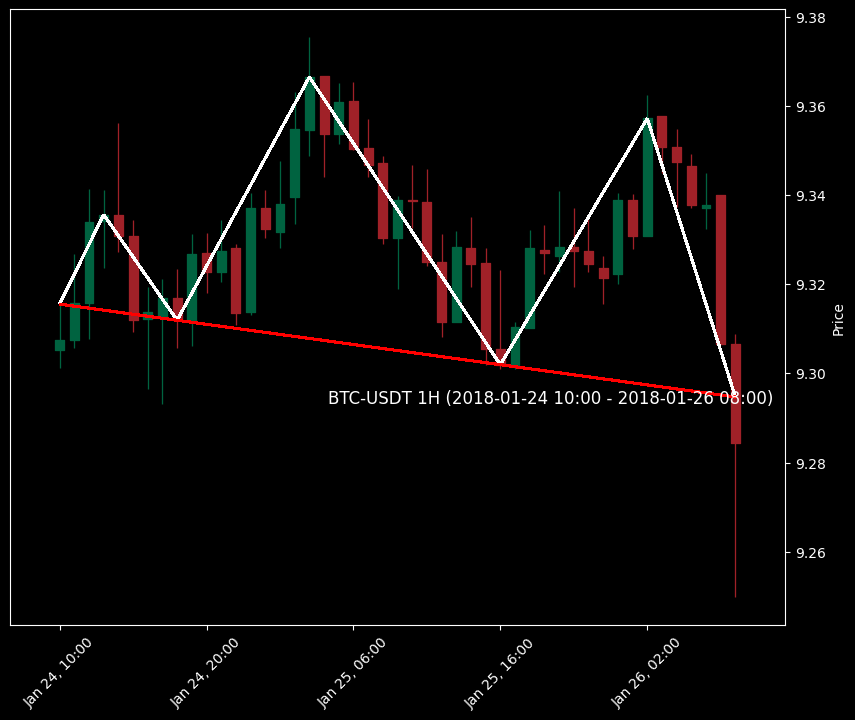

In [11]:
# Main

hs_patterns, ihs_patterns = find_hs_patterns(dat_slice, 6, early_find=False)
   
hs_df = pd.DataFrame()
ihs_df = pd.DataFrame()

# Load pattern attributes into dataframe
for i, hs in enumerate(hs_patterns):
    hs_df.loc[i, 'head_width'] = hs.head_width
    hs_df.loc[i, 'head_height'] = hs.head_height
    hs_df.loc[i, 'r2'] = hs.pattern_r2
    hs_df.loc[i, 'neck_slope'] = hs.neck_slope

    hp = int(hs.head_width)
    if hs.break_i + hp >= len(data):
        hs_df.loc[i, 'hold_return'] = np.nan
    else:
        ret = -1 * (dat_slice[hs.break_i + hp] - dat_slice[hs.break_i])
        hs_df.loc[i, 'hold_return'] = ret 

    hs_df.loc[i, 'stop_return'] = get_pattern_return(dat_slice, hs) 
    
# Load pattern attributes into dataframe
for i, hs in enumerate(ihs_patterns):
    ihs_df.loc[i, 'head_width'] = hs.head_width
    ihs_df.loc[i, 'head_height'] = hs.head_height
    ihs_df.loc[i, 'r2'] = hs.pattern_r2
    ihs_df.loc[i, 'neck_slope'] = hs.neck_slope

    hp = int(hs.head_width)
    if hs.break_i + hp >= len(data):
        ihs_df.loc[i, 'hold_return'] = np.nan
    else:
        ret = dat_slice[hs.break_i + hp] - dat_slice[hs.break_i]
        ihs_df.loc[i, 'hold_return'] = ret 

    ihs_df.loc[i, 'stop_return'] = get_pattern_return(dat_slice, hs) 

plot_hs(data, hs_patterns[0], pad=0)

In [12]:
# Test

orders = list(range(1, 49))
ihs_count = []
ihs_early_count = []
hs_count = []
hs_early_count = []

ihs_wr = []
ihs_early_wr = []
hs_wr = []
hs_early_wr = []

ihs_wr_stop = []
ihs_early_wr_stop = []
hs_wr_stop = []
hs_early_wr_stop = []

ihs_avg = []
ihs_early_avg = []
hs_avg = []
hs_early_avg = []

ihs_avg_stop = []
ihs_early_avg_stop = []
hs_avg_stop = []
hs_early_avg_stop = []


ihs_total_ret = []
ihs_early_total_ret = []
hs_total_ret = []
hs_early_total_ret = []

ihs_total_ret_stop = []
ihs_early_total_ret_stop = []
hs_total_ret_stop = []
hs_early_total_ret_stop = []


for order in tqdm(orders):
    hs_patterns, ihs_patterns = find_hs_patterns(dat_slice, order, False)
    hs_patterns_early, ihs_patterns_early = find_hs_patterns(dat_slice, order, True)
    
    hs_df = pd.DataFrame()
    ihs_df = pd.DataFrame()
    hs_early_df = pd.DataFrame()
    ihs_early_df = pd.DataFrame()

    # Load pattern attributes into dataframe
    for i, hs in enumerate(hs_patterns):
        hs_df.loc[i, 'head_width'] = hs.head_width
        hs_df.loc[i, 'head_height'] = hs.head_height
        hs_df.loc[i, 'r2'] = hs.pattern_r2
        hs_df.loc[i, 'neck_slope'] = hs.neck_slope
        
        hp = int(hs.head_width)
        if hs.break_i + hp >= len(data):
            hs_df.loc[i, 'hold_return'] = np.nan
        else:
            ret = -1 * (dat_slice[hs.break_i + hp] - dat_slice[hs.break_i])
            hs_df.loc[i, 'hold_return'] = ret 
        
        hs_df.loc[i, 'stop_return'] = get_pattern_return(dat_slice, hs) 
    
    for i, hs in enumerate(ihs_patterns):
        ihs_df.loc[i, 'head_width'] = hs.head_width
        ihs_df.loc[i, 'head_height'] = hs.head_height
        ihs_df.loc[i, 'r2'] = hs.pattern_r2
        ihs_df.loc[i, 'neck_slope'] = hs.neck_slope
        
        hp = int(hs.head_width)
        if hs.break_i + hp >= len(data):
            ihs_df.loc[i, 'hold_return'] = np.nan
        else:
            ret = dat_slice[hs.break_i + hp] - dat_slice[hs.break_i]
            ihs_df.loc[i, 'hold_return'] = ret 
        
        ihs_df.loc[i, 'stop_return'] = get_pattern_return(dat_slice, hs) 
    
    for i, hs_early in enumerate(hs_patterns_early):
        hs_early_df.loc[i, 'head_width'] = hs_early.head_width
        hs_early_df.loc[i, 'head_height'] = hs_early.head_height
        hs_early_df.loc[i, 'r2'] = hs_early.pattern_r2
        hs_early_df.loc[i, 'neck_slope'] = hs_early.neck_slope
        
        hp = int(hs_early.head_width)
        if hs_early.break_i + hp >= len(data):
            hs_early_df.loc[i, 'hold_return'] = np.nan
        else:
            ret = -1 * (dat_slice[hs_early.break_i + hp] - dat_slice[hs_early.break_i])
            hs_early_df.loc[i, 'hold_return'] = ret 
        
        hs_early_df.loc[i, 'stop_return'] = get_pattern_return(dat_slice, hs_early) 
    
    # Load pattern attributes into dataframe
    for i, hs_early in enumerate(ihs_patterns_early):
        ihs_early_df.loc[i, 'head_width'] = hs_early.head_width
        ihs_early_df.loc[i, 'head_height'] = hs_early.head_height
        ihs_early_df.loc[i, 'r2'] = hs_early.pattern_r2
        ihs_early_df.loc[i, 'neck_slope'] = hs_early.neck_slope
        
        hp = int(hs_early.head_width)
        if hs_early.break_i + hp >= len(data):
            ihs_early_df.loc[i, 'hold_return'] = np.nan
        else:
            ret = dat_slice[hs_early.break_i + hp] - dat_slice[hs_early.break_i]
            ihs_early_df.loc[i, 'hold_return'] = ret 
        
        ihs_early_df.loc[i, 'stop_return'] = get_pattern_return(dat_slice, hs_early) 
    
    if len(ihs_df) > 0:
        ihs_count.append(len(ihs_df))
        ihs_avg.append(ihs_df['hold_return'].mean())
        ihs_wr.append(len(ihs_df[ihs_df['hold_return'] > 0]) / len(ihs_df))
        ihs_total_ret.append(ihs_df['hold_return'].sum())
        
        ihs_avg_stop.append(ihs_df['stop_return'].mean())
        ihs_wr_stop.append(len(ihs_df[ihs_df['stop_return'] > 0]) / len(ihs_df))
        ihs_total_ret_stop.append(ihs_df['stop_return'].sum())
    else:
        ihs_count.append(0)
        ihs_avg.append(np.nan)
        ihs_wr.append(np.nan)
        ihs_total_ret.append(0)
        
        ihs_avg_stop.append(np.nan)
        ihs_wr_stop.append(np.nan)
        ihs_total_ret_stop.append(0)
    
    if len(hs_df) > 0:
        hs_count.append(len(hs_df))
        hs_avg.append(hs_df['hold_return'].mean())
        hs_wr.append(len(hs_df[hs_df['hold_return'] > 0]) / len(hs_df))
        hs_total_ret.append(hs_df['hold_return'].sum())
        
        hs_avg_stop.append(hs_df['stop_return'].mean())
        hs_wr_stop.append(len(hs_df[hs_df['stop_return'] > 0]) / len(hs_df))
        hs_total_ret_stop.append(hs_df['stop_return'].sum())
    else:
        hs_count.append(0)
        hs_avg.append(np.nan)
        hs_wr.append(np.nan)
        hs_total_ret.append(0)
        
        hs_avg_stop.append(np.nan)
        hs_wr_stop.append(np.nan)
        hs_total_ret_stop.append(0)
    
    if len(ihs_early_df) > 0:
        ihs_early_count.append(len(ihs_early_df))
        ihs_early_avg.append(ihs_early_df['hold_return'].mean())
        ihs_early_wr.append(len(ihs_early_df[ihs_early_df['hold_return'] > 0]) / len(ihs_early_df))
        ihs_early_total_ret.append(ihs_early_df['hold_return'].sum())
        
        ihs_early_avg_stop.append(ihs_early_df['stop_return'].mean())
        ihs_early_wr_stop.append(len(ihs_early_df[ihs_early_df['stop_return'] > 0]) / len(ihs_early_df))
        ihs_early_total_ret_stop.append(ihs_early_df['stop_return'].sum())
    else:
        ihs_early_count.append(0)
        ihs_early_avg.append(np.nan)
        ihs_early_wr.append(np.nan)
        ihs_early_total_ret.append(0)
        
        ihs_early_avg_stop.append(np.nan)
        ihs_early_wr_stop.append(np.nan)
        ihs_early_total_ret_stop.append(0)
    
    if len(hs_early_df) > 0:
        hs_early_count.append(len(hs_early_df))
        hs_early_avg.append(hs_early_df['hold_return'].mean())
        hs_early_wr.append(len(hs_early_df[hs_early_df['hold_return'] > 0]) / len(hs_early_df))
        hs_early_total_ret.append(hs_early_df['hold_return'].sum())
        
        hs_early_avg_stop.append(hs_early_df['stop_return'].mean())
        hs_early_wr_stop.append(len(hs_early_df[hs_early_df['stop_return'] > 0]) / len(hs_early_df))
        hs_early_total_ret_stop.append(hs_early_df['stop_return'].sum())
    else:
        hs_early_count.append(0)
        hs_early_avg.append(np.nan)
        hs_early_wr.append(np.nan)
        hs_early_total_ret.append(0)
        
        hs_early_avg_stop.append(np.nan)
        hs_early_wr_stop.append(np.nan)
        hs_early_total_ret_stop.append(0)

100%|███████████████████████████████████████████████████████████████████| 48/48 [00:11<00:00,  4.07it/s]


In [13]:
results_df = pd.DataFrame(index=orders)
results_df['ihs_count'] = ihs_count
results_df['ihs_avg'] = ihs_avg
results_df['ihs_wr'] = ihs_wr
results_df['ihs_total'] = ihs_total_ret

results_df['ihs_avg_stop'] = ihs_avg_stop
results_df['ihs_wr_stop'] = ihs_wr_stop
results_df['ihs_total_stop'] = ihs_total_ret_stop

results_df['hs_count'] = hs_count
results_df['hs_avg'] = hs_avg
results_df['hs_wr'] = hs_wr
results_df['hs_total'] = hs_total_ret

results_df['hs_avg_stop'] = hs_avg_stop
results_df['hs_wr_stop'] = hs_wr_stop
results_df['hs_total_stop'] = hs_total_ret_stop

results_df['ihs_early_count'] = ihs_early_count
results_df['ihs_early_avg'] = ihs_early_avg
results_df['ihs_early_wr'] = ihs_early_wr
results_df['ihs_early_total'] = ihs_early_total_ret

results_df['ihs_early_avg_stop'] = ihs_early_avg_stop
results_df['ihs_early_wr_stop'] = ihs_early_wr_stop
results_df['ihs_early_total_stop'] = ihs_early_total_ret_stop

results_df['hs_early_count'] = hs_early_count
results_df['hs_early_avg'] = hs_early_avg
results_df['hs_early_wr'] = hs_early_wr
results_df['hs_early_total'] = hs_early_total_ret

results_df['hs_early_avg_stop'] = hs_early_avg_stop
results_df['hs_early_wr_stop'] = hs_early_wr_stop
results_df['hs_early_total_stop'] = hs_early_total_ret_stop

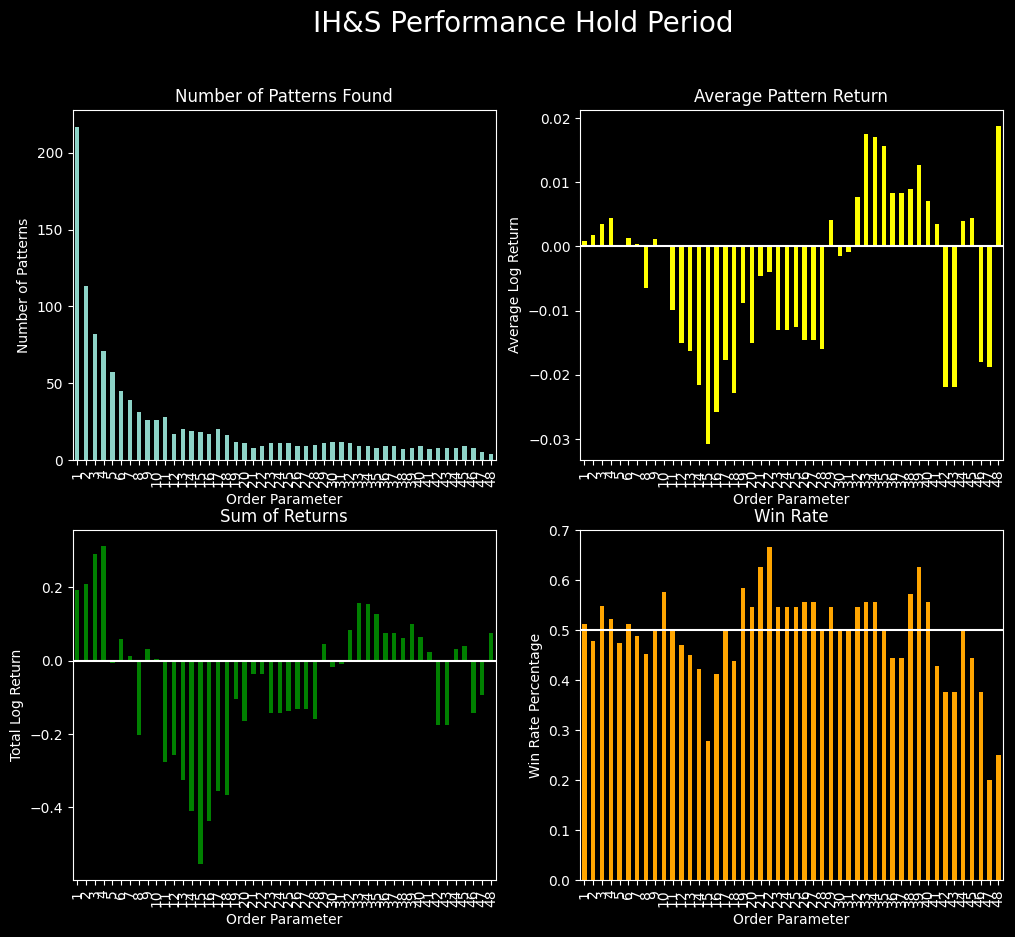

In [14]:
# Plot Hold Period Performance
plt.style.use('dark_background')
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("IH&S Performance Hold Period", fontsize=20)
results_df['ihs_count'].plot.bar(ax=ax[0,0])
results_df['ihs_avg'].plot.bar(ax=ax[0,1], color='yellow')
results_df['ihs_total'].plot.bar(ax=ax[1,0], color='green')
results_df['ihs_wr'].plot.bar(ax=ax[1,1], color='orange')
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='white')
ax[0,0].set_title('Number of Patterns Found')
ax[0,0].set_xlabel('Order Parameter')
ax[0,0].set_ylabel('Number of Patterns')
ax[0,1].set_title('Average Pattern Return')
ax[0,1].set_xlabel('Order Parameter')
ax[0,1].set_ylabel('Average Log Return')
ax[1,0].set_title('Sum of Returns')
ax[1,0].set_xlabel('Order Parameter')
ax[1,0].set_ylabel('Total Log Return')
ax[1,1].set_title('Win Rate')
ax[1,1].set_xlabel('Order Parameter')
ax[1,1].set_ylabel('Win Rate Percentage')
plt.show()

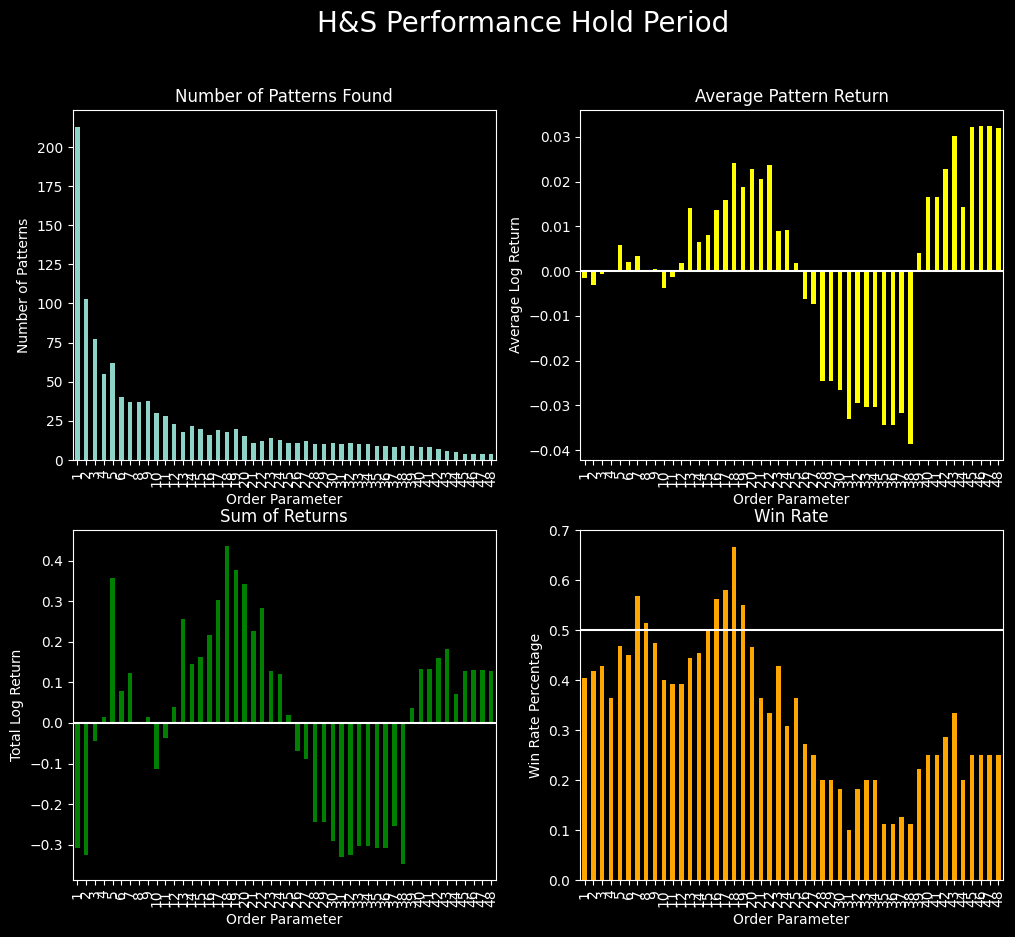

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("H&S Performance Hold Period", fontsize=20)
results_df['hs_count'].plot.bar(ax=ax[0,0])
results_df['hs_avg'].plot.bar(ax=ax[0,1], color='yellow')
results_df['hs_total'].plot.bar(ax=ax[1,0], color='green')
results_df['hs_wr'].plot.bar(ax=ax[1,1], color='orange')
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='white')
ax[0,0].set_title('Number of Patterns Found')
ax[0,0].set_xlabel('Order Parameter')
ax[0,0].set_ylabel('Number of Patterns')
ax[0,1].set_title('Average Pattern Return')
ax[0,1].set_xlabel('Order Parameter')
ax[0,1].set_ylabel('Average Log Return')
ax[1,0].set_title('Sum of Returns')
ax[1,0].set_xlabel('Order Parameter')
ax[1,0].set_ylabel('Total Log Return')
ax[1,1].set_title('Win Rate')
ax[1,1].set_xlabel('Order Parameter')
ax[1,1].set_ylabel('Win Rate Percentage')
plt.show()

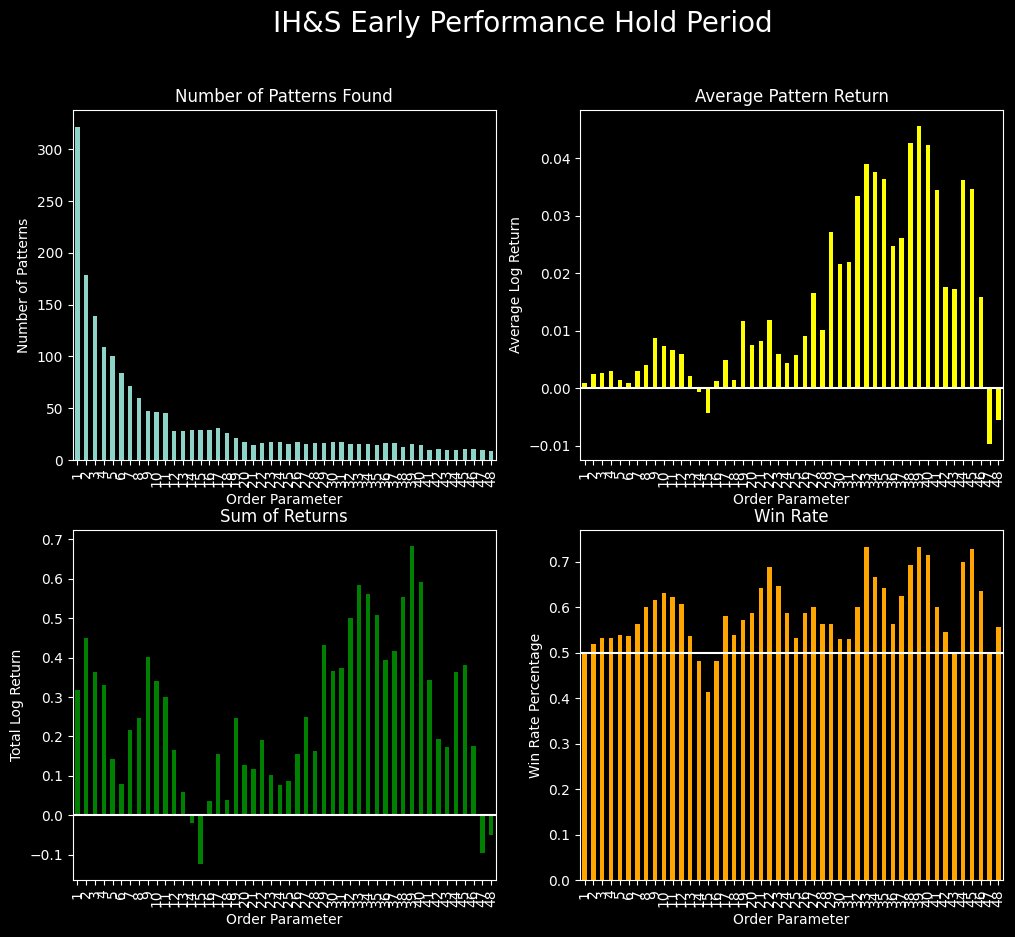

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("IH&S Early Performance Hold Period", fontsize=20)
results_df['ihs_early_count'].plot.bar(ax=ax[0,0])
results_df['ihs_early_avg'].plot.bar(ax=ax[0,1], color='yellow')
results_df['ihs_early_total'].plot.bar(ax=ax[1,0], color='green')
results_df['ihs_early_wr'].plot.bar(ax=ax[1,1], color='orange')
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='white')
ax[0,0].set_title('Number of Patterns Found')
ax[0,0].set_xlabel('Order Parameter')
ax[0,0].set_ylabel('Number of Patterns')
ax[0,1].set_title('Average Pattern Return')
ax[0,1].set_xlabel('Order Parameter')
ax[0,1].set_ylabel('Average Log Return')
ax[1,0].set_title('Sum of Returns')
ax[1,0].set_xlabel('Order Parameter')
ax[1,0].set_ylabel('Total Log Return')
ax[1,1].set_title('Win Rate')
ax[1,1].set_xlabel('Order Parameter')
ax[1,1].set_ylabel('Win Rate Percentage')
plt.show()

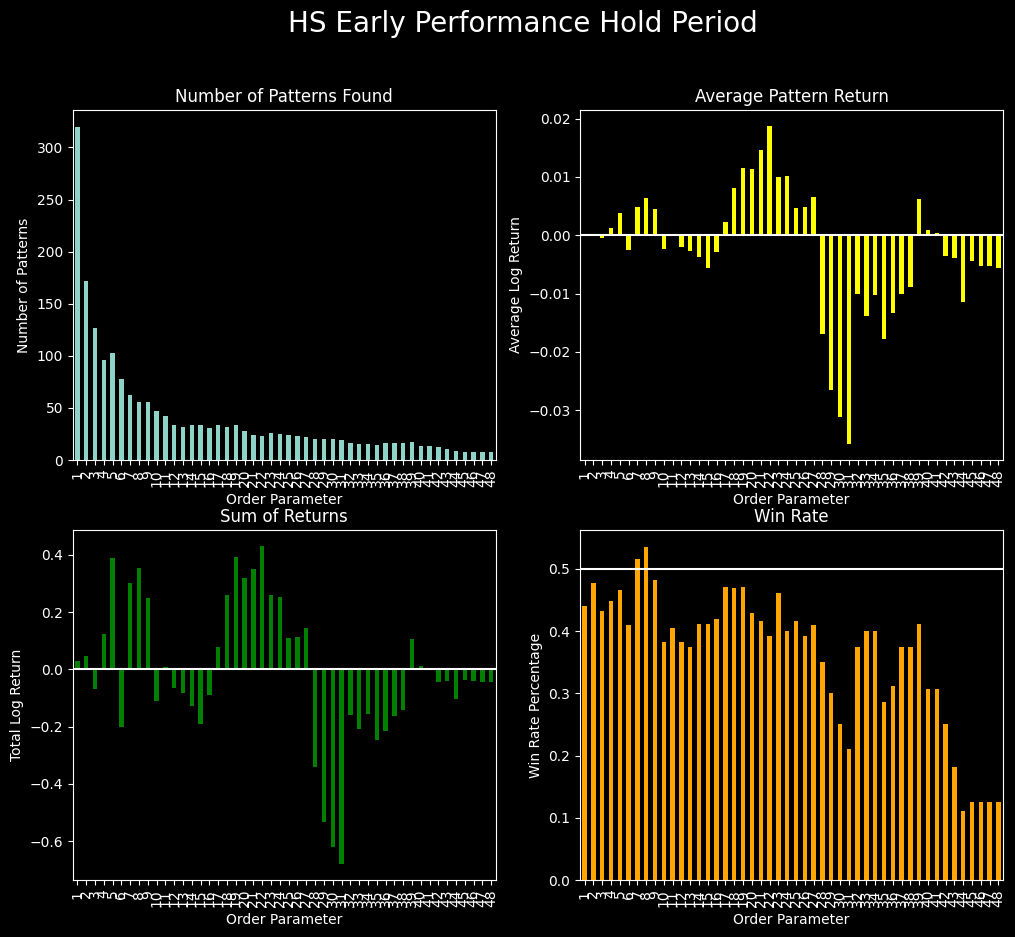

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("HS Early Performance Hold Period", fontsize=20)
results_df['hs_early_count'].plot.bar(ax=ax[0,0])
results_df['hs_early_avg'].plot.bar(ax=ax[0,1], color='yellow')
results_df['hs_early_total'].plot.bar(ax=ax[1,0], color='green')
results_df['hs_early_wr'].plot.bar(ax=ax[1,1], color='orange')
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='white')
ax[0,0].set_title('Number of Patterns Found')
ax[0,0].set_xlabel('Order Parameter')
ax[0,0].set_ylabel('Number of Patterns')
ax[0,1].set_title('Average Pattern Return')
ax[0,1].set_xlabel('Order Parameter')
ax[0,1].set_ylabel('Average Log Return')
ax[1,0].set_title('Sum of Returns')
ax[1,0].set_xlabel('Order Parameter')
ax[1,0].set_ylabel('Total Log Return')
ax[1,1].set_title('Win Rate')
ax[1,1].set_xlabel('Order Parameter')
ax[1,1].set_ylabel('Win Rate Percentage')
plt.show()

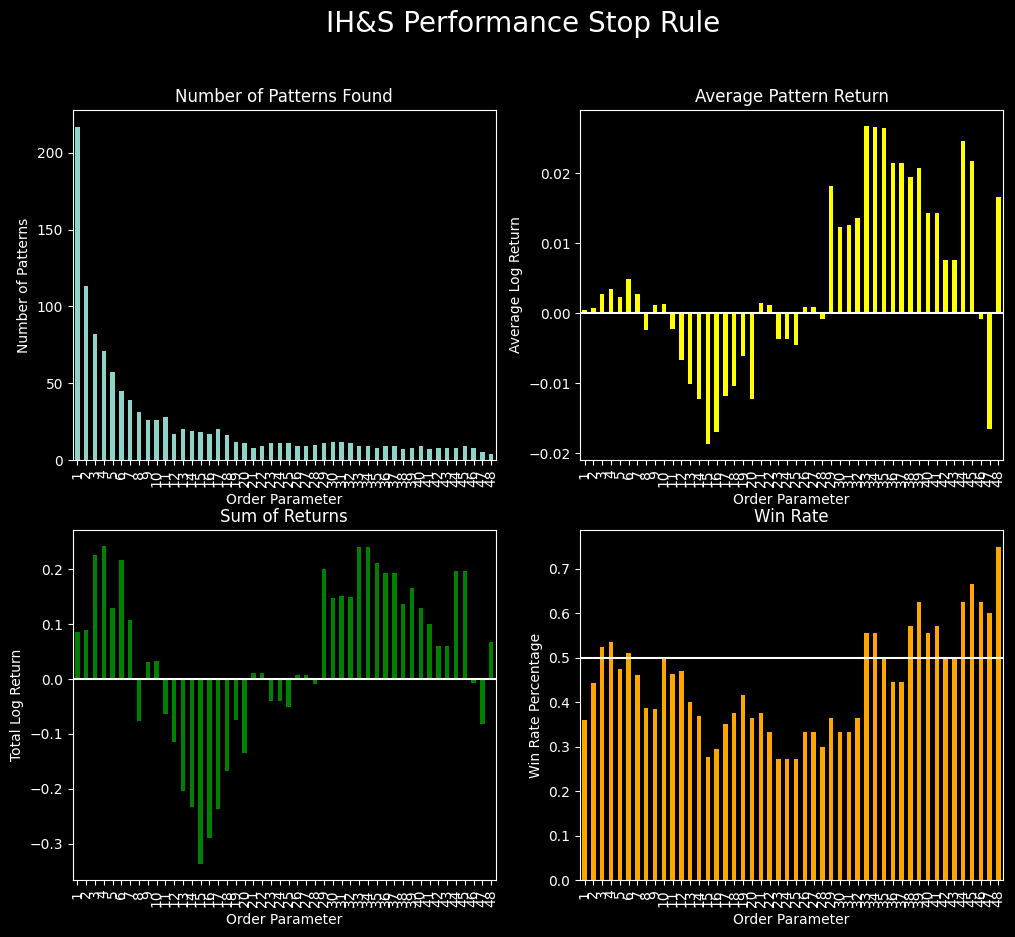

In [18]:
# Plot Stop Rule Performance
plt.style.use('dark_background')
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("IH&S Performance Stop Rule", fontsize=20)
results_df['ihs_count'].plot.bar(ax=ax[0,0])
results_df['ihs_avg_stop'].plot.bar(ax=ax[0,1], color='yellow')
results_df['ihs_total_stop'].plot.bar(ax=ax[1,0], color='green')
results_df['ihs_wr_stop'].plot.bar(ax=ax[1,1], color='orange')
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='white')
ax[0,0].set_title('Number of Patterns Found')
ax[0,0].set_xlabel('Order Parameter')
ax[0,0].set_ylabel('Number of Patterns')
ax[0,1].set_title('Average Pattern Return')
ax[0,1].set_xlabel('Order Parameter')
ax[0,1].set_ylabel('Average Log Return')
ax[1,0].set_title('Sum of Returns')
ax[1,0].set_xlabel('Order Parameter')
ax[1,0].set_ylabel('Total Log Return')
ax[1,1].set_title('Win Rate')
ax[1,1].set_xlabel('Order Parameter')
ax[1,1].set_ylabel('Win Rate Percentage')
plt.show()

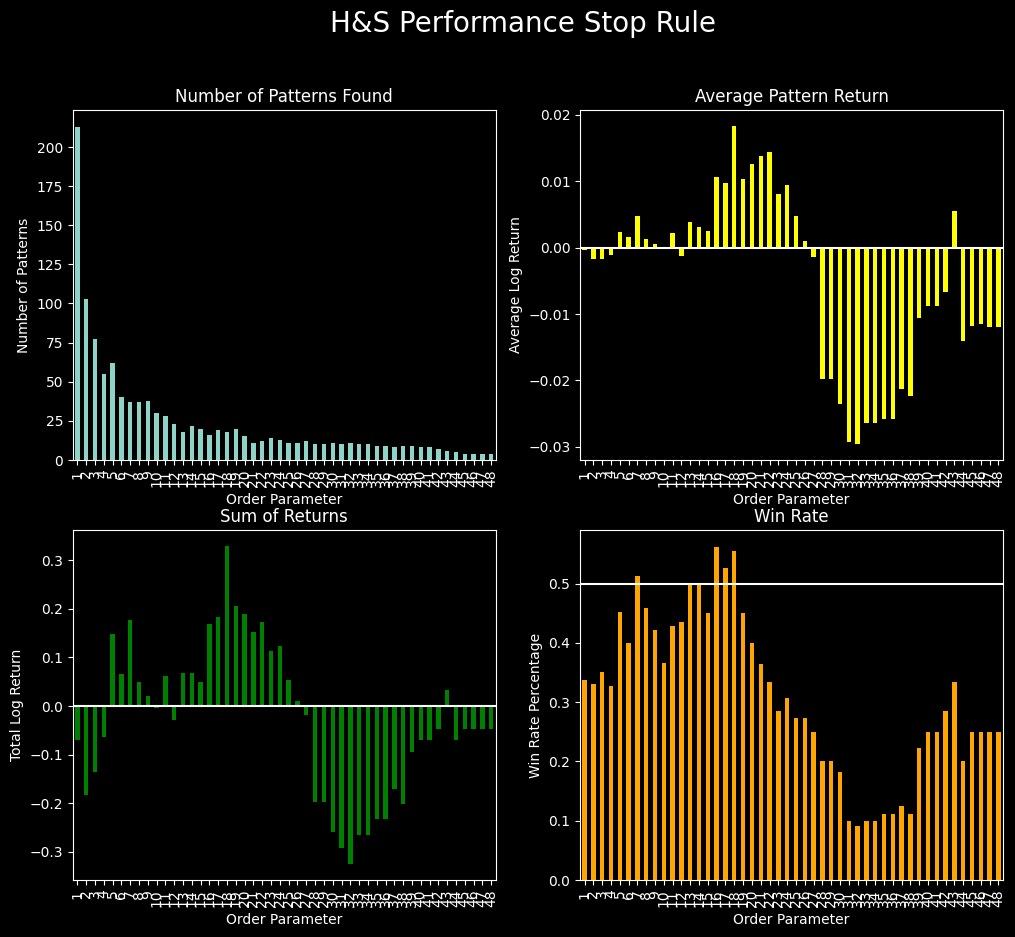

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("H&S Performance Stop Rule", fontsize=20)
results_df['hs_count'].plot.bar(ax=ax[0,0])
results_df['hs_avg_stop'].plot.bar(ax=ax[0,1], color='yellow')
results_df['hs_total_stop'].plot.bar(ax=ax[1,0], color='green')
results_df['hs_wr_stop'].plot.bar(ax=ax[1,1], color='orange')
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='white')
ax[0,0].set_title('Number of Patterns Found')
ax[0,0].set_xlabel('Order Parameter')
ax[0,0].set_ylabel('Number of Patterns')
ax[0,1].set_title('Average Pattern Return')
ax[0,1].set_xlabel('Order Parameter')
ax[0,1].set_ylabel('Average Log Return')
ax[1,0].set_title('Sum of Returns')
ax[1,0].set_xlabel('Order Parameter')
ax[1,0].set_ylabel('Total Log Return')
ax[1,1].set_title('Win Rate')
ax[1,1].set_xlabel('Order Parameter')
ax[1,1].set_ylabel('Win Rate Percentage')
plt.show()

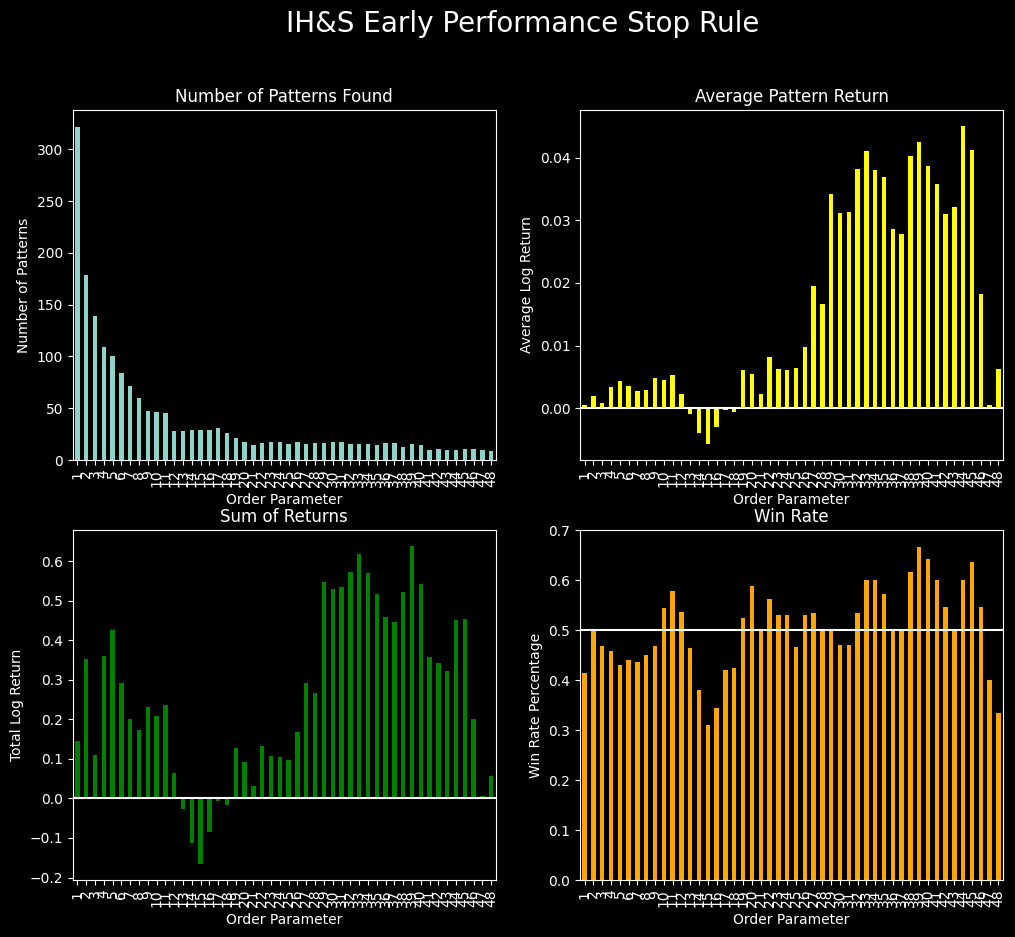

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("IH&S Early Performance Stop Rule", fontsize=20)
results_df['ihs_early_count'].plot.bar(ax=ax[0,0])
results_df['ihs_early_avg_stop'].plot.bar(ax=ax[0,1], color='yellow')
results_df['ihs_early_total_stop'].plot.bar(ax=ax[1,0], color='green')
results_df['ihs_early_wr_stop'].plot.bar(ax=ax[1,1], color='orange')
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='white')
ax[0,0].set_title('Number of Patterns Found')
ax[0,0].set_xlabel('Order Parameter')
ax[0,0].set_ylabel('Number of Patterns')
ax[0,1].set_title('Average Pattern Return')
ax[0,1].set_xlabel('Order Parameter')
ax[0,1].set_ylabel('Average Log Return')
ax[1,0].set_title('Sum of Returns')
ax[1,0].set_xlabel('Order Parameter')
ax[1,0].set_ylabel('Total Log Return')
ax[1,1].set_title('Win Rate')
ax[1,1].set_xlabel('Order Parameter')
ax[1,1].set_ylabel('Win Rate Percentage')
plt.show()

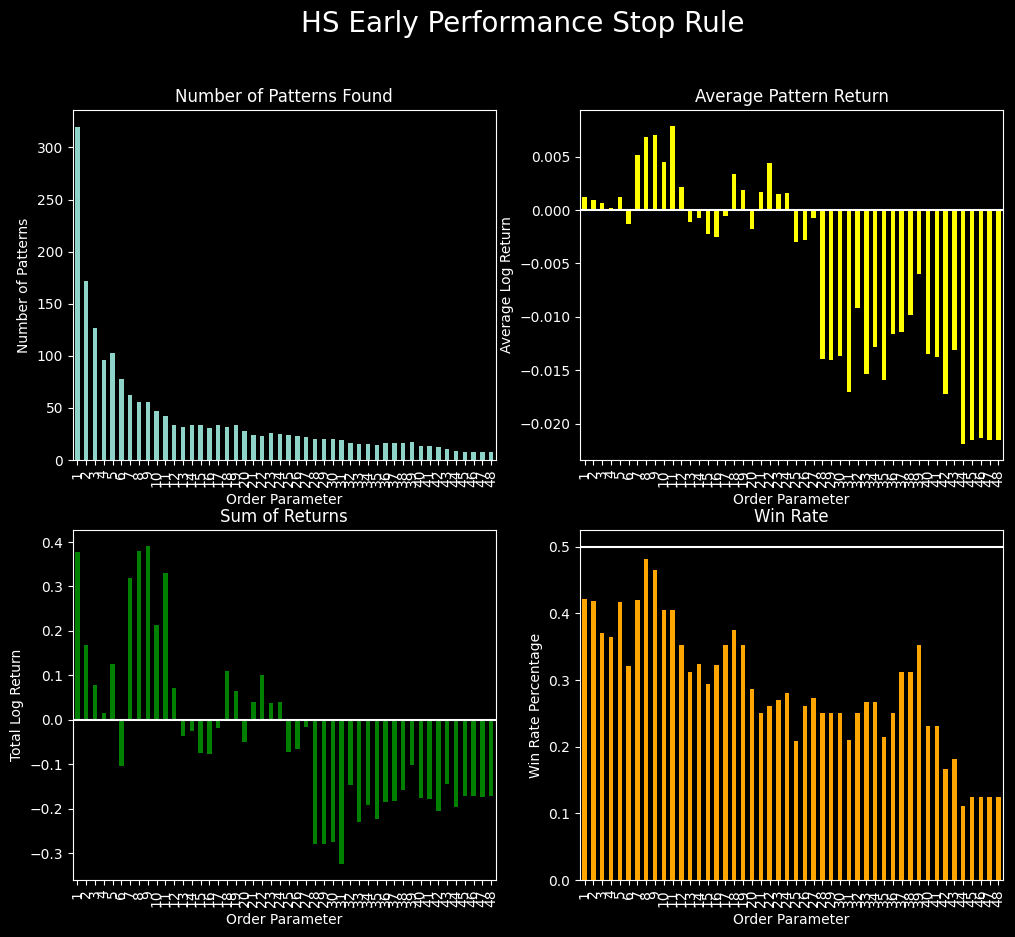

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("HS Early Performance Stop Rule", fontsize=20)
results_df['hs_early_count'].plot.bar(ax=ax[0,0])
results_df['hs_early_avg_stop'].plot.bar(ax=ax[0,1], color='yellow')
results_df['hs_early_total_stop'].plot.bar(ax=ax[1,0], color='green')
results_df['hs_early_wr_stop'].plot.bar(ax=ax[1,1], color='orange')
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='white')
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='white')
ax[0,0].set_title('Number of Patterns Found')
ax[0,0].set_xlabel('Order Parameter')
ax[0,0].set_ylabel('Number of Patterns')
ax[0,1].set_title('Average Pattern Return')
ax[0,1].set_xlabel('Order Parameter')
ax[0,1].set_ylabel('Average Log Return')
ax[1,0].set_title('Sum of Returns')
ax[1,0].set_xlabel('Order Parameter')
ax[1,0].set_ylabel('Total Log Return')
ax[1,1].set_title('Win Rate')
ax[1,1].set_xlabel('Order Parameter')
ax[1,1].set_ylabel('Win Rate Percentage')
plt.show()